# Prediction of Used Car Prices - ML/AI Career Path Portfolio Project

This project focuses on a dataset that contains information of used cars from the year 1974 to 2024 such as its brand, type and model. The purpose of this project is to use machine learning algorithms and machine learning pipelines to predict used car prices. 

The original dataset was provided by Kaggle and modified by a user from Kaggle (https://www.kaggle.com/datasets/anthonytherrien/extended-dataset-for-used-car-prices-regressiont). The user had generated values using OpenAI's GPT-4o-mini for additional data points to provide more insights and potentially improve model performance. Despite these synthetic data points, the accuracy of these data points were maintained and can be assumed to replicate real-world scenarios. We will be using Python and its libraries to complete this project.

## Goal of project

1. Apply machine learning algorithms to a dataset and perform predictive analysis 
2. Create a ML pipeline to automate ML workflow
3. Achieve a root mean squared error as close to 0 as possible

## Import Libraries

In [233]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

## Load and Inspect Data

In [234]:
test_set = pd.read_csv('test.csv')
train_set = pd.read_csv('train.csv')

In [235]:
train_set.info()
train_set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


The dataset contains 188533 rows and 13 columns containing information on various used cars. It seems that all of the columns except 'fuel_type', 'clean_title' and 'accident' do not have null values.

Here's a quick summary of the columns:

- **id**: The identification number of the vehicle.
- **brand**: The manufacturer of the vehicle.
- **model**: The specific model of the vehicle produced by the brand. 
- **milage**: The milage of the vehicle. 
- **fuel_type**: The type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
- **engine**: The engine specifications of the vehicle.
- **transmission**: The transmission type, whether automatic, manual, or another variant.
- **ext_col**: The exterior color of the vehicle.
- **int_col**: The interior color of the vehicle.
- **accident**: The vehicle's history of accidents or damages.
- **clean_title**: The availability of a clean title.
- **price**: The listed prices for the vehicle.

## Data Cleaning and Preparation

### Training Set

#### Fuel Type

Firstly, we will deal with the 'fuel_type' column.

In [236]:
train_set.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [237]:
train_set.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

Since gasoline vehicles are the most common, we will replace the '-', 'not supported' and null values with 'Gasoline'.

In [238]:
train_set['fuel_type'].replace(['–','not supported'], 'Gasoline', inplace = True)
train_set['fuel_type'].fillna('Gasoline', inplace = True)
train_set['fuel_type'].replace('Plug-In Hybrid', 'Hybrid', inplace = True)

In [239]:
train_set.fuel_type.value_counts()

fuel_type
Gasoline         171819
Hybrid             7353
E85 Flex Fuel      5406
Diesel             3955
Name: count, dtype: int64

#### Clean Title

Next, we will make the 'clean_title' into a binary field by replacing 'Yes' with 1 and the null values with 0.

In [240]:
train_set.clean_title.unique()

array(['Yes', nan], dtype=object)

In [241]:
train_set.clean_title.replace('Yes', 1, inplace = True)
train_set.clean_title.fillna(0, inplace = True)

#### Accidents

Lastly, we will do the same with the 'accident' column.

In [242]:
train_set.accident.unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [243]:
train_set.accident.replace(['No', 'None reported'], 0, inplace=True)
train_set.accident.replace('At least 1 accident or damage reported', 1, inplace=True)
train_set.accident.fillna(0, inplace=True)

#### Engine

In [244]:
train_set.engine.unique()

array(['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel',
       '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel',
       '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability', ...,
       '78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel',
       '139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas',
       '313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas'],
      dtype=object)

### Testing Set

In [245]:
test_set.info()
test_set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


It seems that the 'fuel_type', 'accident' and 'clean_title' columns have null values, similarly to the training dataset. We will deal with these values the same way as in the training set.

#### Fuel Type

In [276]:
test_set['fuel_type'].replace(['–','not supported'], 'Gasoline', inplace = True)
test_set['fuel_type'].fillna('Gasoline', inplace = True)
test_set['fuel_type'].replace('Plug-In Hybrid', 'Hybrid', inplace = True)

#### Clean Title

In [247]:
test_set.clean_title.replace('Yes', 1, inplace = True)
test_set.clean_title.fillna(0, inplace = True)

#### Accidents

In [248]:
test_set.accident.replace(['No', 'None reported'], 0, inplace=True)
test_set.accident.replace('At least 1 accident or damage reported', 1, inplace=True)
test_set.accident.fillna(0, inplace=True)

### Transmission Type

There are a lot of transmission types in the training and testing dataset. We will categorise them into 4 different types; Automatic, Manual, CVT, Dual Shift and Others.

In [249]:
test_set.transmission.unique()

array(['6-Speed A/T', '8-Speed A/T', '10-Speed Automatic', 'Automatic',
       'A/T', 'Transmission w/Dual Shift Mode', '6-Speed Automatic',
       '7-Speed A/T', '5-Speed M/T', '8-Speed Automatic', '9-Speed A/T',
       '10-Speed A/T', '9-Speed Automatic', '5-Speed Automatic',
       'Automatic CVT', '6-Speed M/T', 'CVT Transmission',
       'Transmission Overdrive Switch', 'M/T', '7-Speed Automatic',
       '5-Speed A/T', '1-Speed A/T', '7-Speed Automatic with Auto-Shift',
       '4-Speed A/T', '9-Speed Automatic with Auto-Shift',
       '8-Speed Automatic with Auto-Shift', 'Variable',
       '10-Speed Automatic with Overdrive', '1-Speed Automatic',
       '7-Speed M/T', '6-Speed Manual', '2-Speed Automatic', 'F',
       '2-Speed A/T', '4-Speed Automatic',
       '6-Speed Automatic with Auto-Shift', '2', '6 Speed Mt',
       '7-Speed Manual', '–', '8-Speed Manual', 'Manual',
       '6-Speed Electronically Controlled Automatic with O',
       '8-SPEED A/T', '7-Speed', '7-Speed DCT Aut

In [250]:
auto = ['Auto', 'A/T', 'SCHEDULED', '–', 'F', 'AT', '2', '7-Speed', '6-Speed']
manual = ['Manual', 'M/T', 'MT', 'Mt']

def transmission(type):
    if any(x in type for x in auto):
        return 'Automatic'
    elif any(x in type for x in manual):
        return 'Manual'
    elif 'CVT' in type or 'Variable' in type:
        return 'CVT' 
    elif 'Dual Shift' in type:
        return 'Dual Shift Mode'
    elif 'Overdrive' in type:
        return 'Overdrive Switch'
    else:
        return 'Others'

def speed(type):
    for speed in range(1,11):
        if str(speed) in type:
            return speed 
    
train_set['transmission_type'] = train_set.transmission.apply(transmission)
test_set['transmission_type'] = test_set.transmission.apply(transmission)

In [251]:
train_set.transmission_type.value_counts()

transmission_type
Automatic           163366
Dual Shift Mode      19255
Manual                3700
CVT                   2056
Overdrive Switch       156
Name: count, dtype: int64

### Brand

We will perform frequency encoding on the 'brand' column since there are a lot of brands.

In [293]:
frequency_encoding_train = train_set['brand'].value_counts().to_dict()
train_set['encoded_brand'] = train_set['brand'].map(frequency_encoding)

frequency_encoding_test = test_set['brand'].value_counts().to_dict()
test_set['encoded_brand'] = test_set['brand'].map(frequency_encoding_test)

### Horsepower

In [283]:
# Extracting horsepower from 'engine' column
train_set['horsepower'] = train_set['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
test_set['horsepower'] = test_set['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

# Filling null values with mode value
train_set['horsepower'].fillna(train_set['horsepower'].mode()[0], inplace=True)
test_set['horsepower'].fillna(test_set['horsepower'].mode()[0], inplace=True)

### Finding Correlations or Outliers

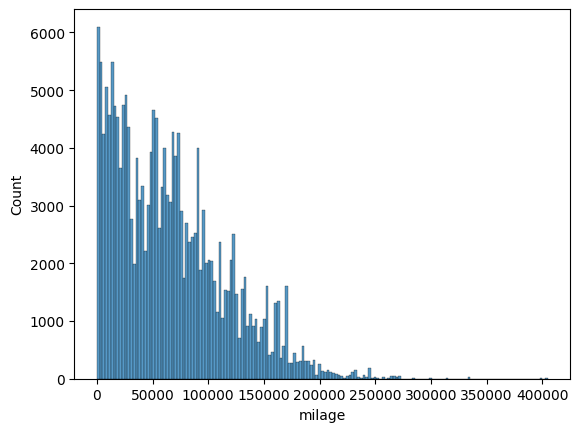

In [257]:
sns.histplot(data = train_set, x = 'milage')
plt.show()

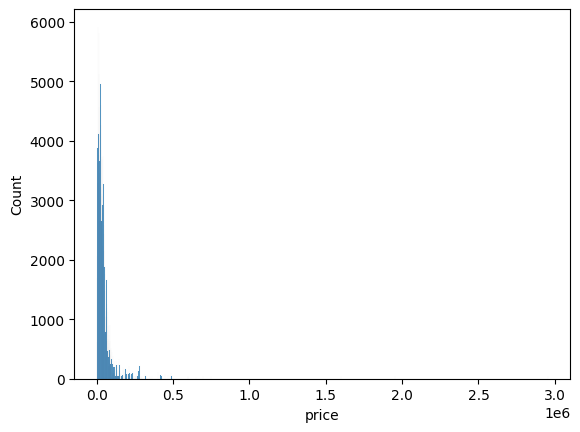

In [258]:
sns.histplot(data = train_set, x = 'price')
plt.show()

## Pipeline

In [260]:
columns = ['encoded_brand', 'model_year', 'milage', 'fuel_type', 'accident', 'transmission_type', 'horsepower']
y = train_set.price
X = train_set[columns]

In [261]:
feature_cols = ['encoded_brand', 'model_year', 'milage', 'horsepower']
X = train_set[feature_cols]
y = train_set.price

# Separate column types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.drop('encoded_brand')
cat_cols = X.select_dtypes(include=['object', 'category']).columns
bin_cols = X.columns[(X.nunique() == 2)]  # Columns with only two unique values (binary)
freq_cols = 'encoded_brand'

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # Scale numerical columns
        ('cat', OneHotEncoder(drop='first', sparse=False), cat_cols),  # One-Hot Encode categorical columns
        ('bin', 'passthrough', bin_cols),  # Keep binary columns as they are
        ('freq', 'passthrough', [freq_cols])
    ])

## Feature Importances

In [262]:
# Apply the transformations to the training data
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

# Split the data into train and test sets
x_train_processed, x_test_processed, y_train_processed, y_test_processed = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [263]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model to the training data
rf.fit(x_train_processed, y_train_processed)

RandomForestRegressor(random_state=0)

In [264]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to view feature importances
feature_importances = pd.DataFrame({'feature': x_train_processed.columns, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print the top 10 most important features
print(feature_importances.head(15))

               feature  importance
1          num__milage    0.559173
0      num__model_year    0.174559
2      num__horsepower    0.135306
3  freq__encoded_brand    0.130963


In [265]:
# plt.figure(figsize=(6, 4))
# sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
# plt.title('Top 10 Feature Importances from RandomForestRegressor')
# plt.show()

In [266]:
# Select the top 10 most important features
# top_features = feature_importances['feature'].head(15)
# X_train_top = x_train[top_features]
# X_test_top = x_test[top_features]

## Training Model

### GridSearchCV

In [267]:
# # Train the RandomForestRegressor again with the selected top features
# rf_top = RandomForestRegressor(random_state = 0)

# param_grid = {
#     'n_estimators': [50,100,200],              
#     'max_depth': [10, 20, None],
#     'bootstrap': [True, False]                   
# }

# gs = GridSearchCV(estimator = rf_top, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
# gs.fit(x_train, y_train)

# best_rf = gs.best_estimator_

# # Evaluate the model on the test set
# y_pred = best_rf.predict(X_test_top)

In [268]:
# Calculate performance metrics
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

# # acc_score = rf_top.score(y_test, y_pred)
# print(f'Accuracy Score: {acc_score}')

### Fitting model

In [271]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([('preprocess', preprocessor), ('regressor', GradientBoostingRegressor(random_state = 0, 
                                                                                       n_estimators = 300,
                                                                                       max_depth=5, min_samples_leaf=4,  # Increase min samples per leaf
                                                                                       min_samples_split=5  # Increase min samples per split
                                                                                        ))])

In [272]:
pipeline.fit(x_train, y_train)

# Fit the pipeline on the training data and predict on the test data
y_pred = pipeline.predict(x_test)

#Pipeline score
train_score = pipeline.score(x_train, y_train)
test_score = pipeline.score(x_test, y_test)
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

# Mean squared error score
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
print(f'Root Mean Squared Error: {rmse}')

Train Score: 0.2763705940492488
Test Score: 0.14139727080314024
Root Mean Squared Error: 67335.94436133509


### Stacking

In [273]:
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define base models
rf = RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=3, random_state=0)
gbr = GradientBoostingRegressor(n_estimators=200, random_state=0)
knn = KNeighborsRegressor(n_neighbors=5)

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_regressor = StackingRegressor(
    regressors=[rf, gbr, knn],  # Base models
    meta_regressor=meta_model  # Meta-model
)

In [275]:
pipeline = Pipeline([('preprocess', preprocessor), ('regressor', stacking_regressor)])

# Fit the stacking model on the training data
pipeline.fit(x_train, y_train)

#Pipeline score
train_score = pipeline.score(x_train, y_train)
test_score = pipeline.score(x_test, y_test)
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

# Mean squared error score
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
print(f'Root Mean Squared Error: {rmse}')

Train Score: 0.29892424729819145
Test Score: -0.0032623514126708386
Root Mean Squared Error: 67335.94436133509


### RandomizedSearchCV

In [226]:
# param_grid = {
#     'regressor__n_estimators': [100, 200],
# }

# # Grid search using previous pipeline
# rsv = GridSearchCV(estimator=pipeline, param_grid = param_grid, cv=2, scoring='neg_mean_squared_error')

In [227]:
# Fit rsv using training data and print best score
# rsv.fit(x_train, y_train)

# best_rf = rsv.best_estimator_

# # Evaluate the model on the test set
# y_pred = best_rf.predict(X_test_top)

In [228]:
# Calculate performance metrics
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

# acc_score = rf_top.score(y_test, y_pred)
# print(f'Accuracy Score: {acc_score}')

## Testing model

In [363]:
# Predicting car price
test = test_set[feature_cols]
y_pred_test = pipeline.predict(test)
price_test = pd.Series(y_pred_test)

In [365]:
# Combining car id and predicted price 
car_id = test_set.id
final_df = pd.concat([car_id, price_test], axis = 1)

# Renaming columns
final_df.rename(columns = {0:'price'}, inplace = True)
final_df.head()

,id,price
0,188533,17320.242390
1,188534,91450.567364
2,188535,67691.926926
3,188536,29194.017180
4,188537,29780.586920


In [367]:
import os
path = r'C:\Users\user\Downloads'
final_df.to_csv(os.path.join(path,r'predicted_car_prices.csv'))